# Part 2 - Data Analysis

For this project, the requirement is to use the flights dataset to predict if a particular flight in the future will be cancelled. This first notebook is used to explore the data.



In [1]:
#The various imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

## Create the Spark session
Connect to spark using the standard Spark Session connector. I've put the connection parameters into each file directly they change dependingo the type of job that is running. You should adjust the following for your specific Spark environment.

+ `spark.executor.memory`
+ `spark.executor.cores`
+ `spark.driver.memory` 

Spark will use the default `master` setting when connecting to the resource manager. With Cloudera CML, this will be Spark on Kubernetes. If you are working on you local machine for testing, add `.master("local[*]")\` before `.getOrCreate()`     

The next on is specific to the Cloudera CML setup:

`spark.yarn.access.hadoopFileSystems s3a://[s3 bucket location]`

In [2]:
storage = os.getenv("STORAGE")

spark = SparkSession\
    .builder\
    .appName("Airline Data Exploration")\
    .config("spark.executor.memory","8g")\
    .config("spark.executor.cores","4")\
    .config("spark.driver.memory","6g")\
    .config("spark.yarn.access.hadoopFileSystems",storage)\
    .getOrCreate()

## Load the Spark UI
This creates a link the Spark UI. Its specific to CML and needed because of an issue wit TLS that is being fixed. If you are running locally, just run `spark` as a command in a cell and it will provide you with the Spark UI link.

In [3]:
from IPython.core.display import HTML
HTML('<a href="http://spark-{}.{}" target="_blank">Spark UI</a>'.format(os.getenv("CDSW_ENGINE_ID"),os.getenv("CDSW_DOMAIN")))

## Import the data
This file was downloaded from [Kaggle](https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018) as a CSV and upload to S3. Since we know the schema already, we can make its correct by defining the schema for the import rather than relying on inferSchema. Its also faster! 

_Note: If you are working in local mode, you should limit the number of rows that are returned._

> _HANDY TIP_
> 
> Use `.persist()` on a data frame that you are work a lot with to prevent Spark from fetching the data everytime you run query. It will store that dataframe in memory and all operations on that dataframe will run on the in-memory version.

In [4]:
flight_df = spark.sql("select * from airline_ontime_parquet.flights_external")

# Uncomment this if you are running in local mode and just want to see things work
#flight_df = flight_df.limit(10000)

flight_df.persist()

DataFrame[month: int, dayofmonth: int, dayofweek: int, deptime: int, crsdeptime: int, arrtime: int, crsarrtime: int, uniquecarrier: string, flightnum: int, tailnum: string, actualelapsedtime: int, crselapsedtime: int, airtime: int, arrdelay: int, depdelay: int, origin: string, dest: string, distance: int, taxiin: int, taxiout: int, cancelled: int, cancellationcode: string, diverted: string, carrierdelay: int, weatherdelay: int, nasdelay: int, securitydelay: int, lateaircraftdelay: int, year: int]

## Cancelled Flights by Carrier
The first bit of data exploration is to check the flight cancellations by carrier. This is best done by showing which carrier has the highet percentage of cancelled flights rather than the total number of cancelled flights. 

Concepts introduced in this section:
+ `filter()`,`groupby` etc.
+ `withColumn` and `withColumnRenamed`
+ `toPandas()`

In [5]:
flight_df.printSchema()

root
 |-- month: integer (nullable = true)
 |-- dayofmonth: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- deptime: integer (nullable = true)
 |-- crsdeptime: integer (nullable = true)
 |-- arrtime: integer (nullable = true)
 |-- crsarrtime: integer (nullable = true)
 |-- uniquecarrier: string (nullable = true)
 |-- flightnum: integer (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- actualelapsedtime: integer (nullable = true)
 |-- crselapsedtime: integer (nullable = true)
 |-- airtime: integer (nullable = true)
 |-- arrdelay: integer (nullable = true)
 |-- depdelay: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- distance: integer (nullable = true)
 |-- taxiin: integer (nullable = true)
 |-- taxiout: integer (nullable = true)
 |-- cancelled: integer (nullable = true)
 |-- cancellationcode: string (nullable = true)
 |-- diverted: string (nullable = true)
 |-- carrierdelay: integer (nullable 

In [8]:
cancel_by_carrier = flight_df\
  .filter("cancelled == 1")\
  .groupby("uniquecarrier")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_delays')

  
flight_by_carrier = flight_df\
  .groupby("uniquecarrier")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_total')

  
cancel_by_carrier_percent = flight_by_carrier\
  .join(
    cancel_by_carrier, 
    flight_by_carrier.uniquecarrier == cancel_by_carrier.uniquecarrier
  )
  
cancel_by_carrier_percent = cancel_by_carrier_percent\
  .withColumn(
    "delay_percent",(
      cancel_by_carrier_percent.count_delays/cancel_by_carrier_percent.count_total
    )*100
  )\
  .sort("delay_percent",ascending=False)\
  .toPandas()

# This limits
cancel_by_carrier_percent.head(10)


,uniquecarrier,count_total,uniquecarrier,count_delays,delay_percent
0,MQ,3954895,MQ,157478,3.981850
1,YV,854056,YV,30050,3.518505
2,OH,1464176,OH,47174,3.221880
3,DH,693047,DH,22176,3.199783
4,9E,521059,9E,15039,2.886237
5,EV,1697172,EV,48676,2.868065
6,UA,8821384,UA,232829,2.639370
7,NW,6946627,NW,176539,2.541363
8,US,8286980,US,203291,2.453137
9,TW,1890420,TW,45943,2.430306


# Cancelled flights by Year
This is not necessarily useful as a predictive metric, but it is still interesting.

In [11]:
flight_by_year = flight_df\
  .groupby("year")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_total')
  
cancel_by_year = flight_df\
  .filter("cancelled == 1")\
  .withColumnRenamed("year","year_cancel")\
  .groupby("year_cancel")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'cancel_total')

cancel_by_year_percent = flight_by_year\
  .join(
    cancel_by_year, 
    flight_by_year.year == cancel_by_year.year_cancel
  )  
  
cancel_by_year_percent = cancel_by_year_percent\
  .withColumn(
    "delay_percent",(
      cancel_by_year_percent.cancel_total/cancel_by_year_percent.count_total
    )*100
  )\
  .sort("year",ascending=False)
  
cancel_by_year_percent_pd = cancel_by_year_percent.toPandas()

Plot this using a Tufte-like layout :)

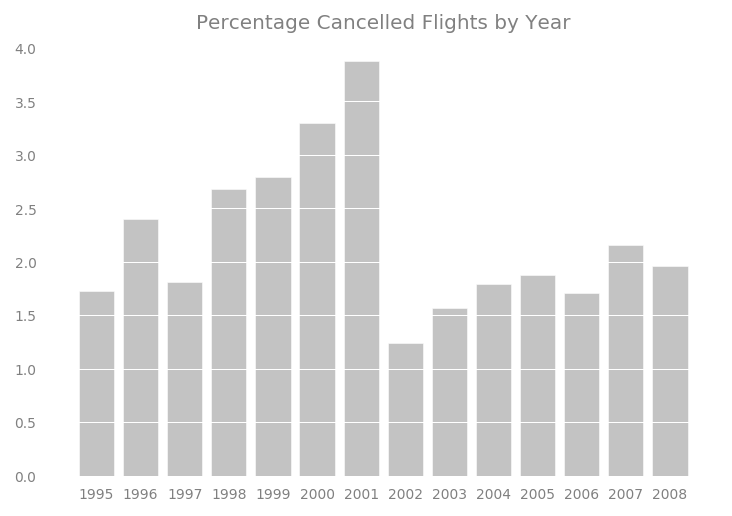

In [12]:
sns.set_style("white",{'axes.axisbelow': False})
plt.bar( 
cancel_by_year_percent_pd.year, 
cancel_by_year_percent_pd.delay_percent,
align='center', 
alpha=0.5,
color='#888888',
)
plt.grid(color='#FFFFFF', linestyle='-', linewidth=0.5, axis='y')
plt.title(
'Percentage Cancelled Flights by Year',
color='grey'
)
plt.xticks(
cancel_by_year_percent_pd.year,
color='grey'
)
plt.yticks(color='grey')
sns.despine(left=True,bottom=True)

## Cancelled flights per Week of Year
This is a more intersting statistic and likely to have more predictive power. Week of Year will be a seasonal and generally the flight patterns will have busier vs less busy times of the year. This will also show the effect that seasonal weather conditions can have on flight cancellations.

In [13]:
flight_by_week = flight_df\
  .withColumn("date",to_date(concat_ws("-","year","month","dayofmonth")))\
  .withColumn("week",weekofyear("date"))\
  .groupby("week")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_total')
  
cancel_by_week = flight_df\
  .filter("cancelled == 1")\
  .withColumn("date",to_date(concat_ws("-","year","month","dayofmonth")))\
  .withColumn("week",weekofyear("date"))\
  .withColumnRenamed("week","week_cancel")\
  .groupby("week_cancel")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'cancel_total')

cancel_by_week_percent = flight_by_week\
  .join(
    cancel_by_week, 
    flight_by_week.week == cancel_by_week.week_cancel
  )  
  
cancel_by_week_percent = cancel_by_week_percent\
  .withColumn(
    "delay_percent",(
      cancel_by_week_percent.cancel_total/cancel_by_week_percent.count_total
    )*100
  )\
  .sort("week",ascending=False)
  
cancel_by_week_percent_pd = cancel_by_week_percent.toPandas()

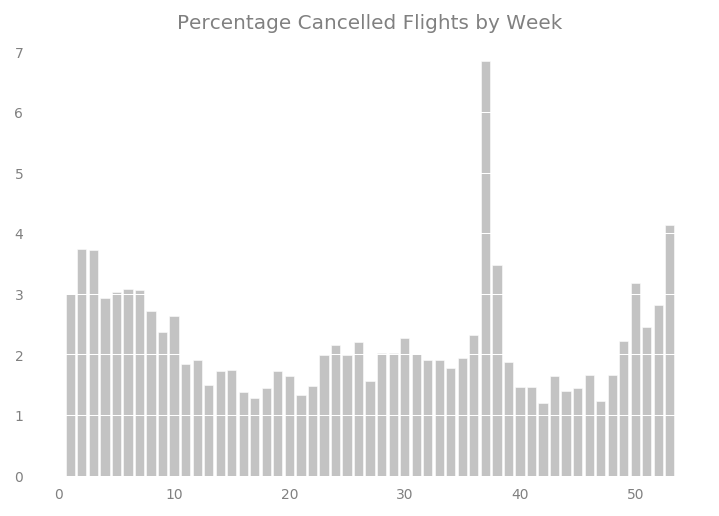

In [14]:
def plotter():
  sns.set_style("white",{'axes.axisbelow': False})
  plt.bar( 
    cancel_by_week_percent_pd.week, 
    cancel_by_week_percent_pd.delay_percent,
    align='center', 
    alpha=0.5,
    color='#888888',
  )
  plt.grid(color='#FFFFFF', linestyle='-', linewidth=0.5, axis='y')
  plt.title(
    'Percentage Cancelled Flights by Week',
    color='grey'
  )
  plt.xticks(
    color='grey'
  )
  plt.yticks(color='grey')
  sns.despine(left=True,bottom=True)
plotter()

## Calculating Cancelled Routes
To work out if route is likely to cancalled, the easiest way is to create a string that combines the origin and destination. However that works only in on direction, so calculate for both directions, the code below uses `hash` to create an interger that is the sum of the a of the origin and a hash of the destination. This creates a commutative process for any route.


> HANDY TIP
> In pyspark you can aggregate inside a `select` function (i.e. use `sum` etc) if its not after a groupby

In [15]:
all_routes = flight_df\
  .withColumn("combo_hash", hash("origin")+hash("dest"))\
  .withColumn("combo", concat(col("origin"),col("dest")))\
  .groupby("combo_hash")\
  .agg(count("combo_hash").alias("count_all"),first("combo").alias("route_alias_all"))\
  .sort("count_all",ascending=False)

cancelled_routes_all = flight_df\
  .filter("cancelled == 1")\
  .withColumn("combo_hash", hash("origin")+hash("dest"))\
  .withColumn("combo", concat(col("origin"),col("dest")))\
  .groupby("combo_hash")\
  .agg(count("combo_hash").alias("count"),first("combo").alias("route_alias"))\
  .sort("count",ascending=False)  

cancelled_routes_percentage = cancelled_routes_all\
  .join(
    all_routes,
    cancelled_routes_all.combo_hash == all_routes.combo_hash
  )\
  .withColumn(
    "route", 
    concat(
      substring(col("route_alias"),0,3),
      lit("<>"),
      substring(col("route_alias"),4,6)
    )
  )\
  .withColumn(
    "cancelled_percent", 
    col("count")/col("count_all")*100
  )\
  .select("route","count","count_all","cancelled_percent")\
  .sort("cancelled_percent",ascending=False)

cancelled_routes_percentage.toPandas().head(10)

,route,count,count_all,cancelled_percent
0,CID<>DSM,1,1,100.0
1,PIA<>MDW,1,1,100.0
2,HPN<>ALB,1,1,100.0
3,HPN<>LGA,2,2,100.0
4,RIC<>GSO,1,1,100.0
5,SMF<>MSN,1,1,100.0
6,BMI<>PIA,1,1,100.0
7,HNL<>GUM,1,1,100.0
8,AUS<>ORF,1,1,100.0
9,TLH<>JAX,1,1,100.0


### Side Note
Interestingly most popular routes have similar numbers of cancelled flights in either direction.

In [16]:
cancelled_by_route_non_combo = flight_df\
  .filter("cancelled == 1")\
  .withColumn("combo", concat(col("origin"),col("dest")))\
  .groupby("combo")\
  .count()\
  .sort("count",ascending=False)

cancelled_by_route_non_combo.toPandas().head(10)

,combo,count
0,LAXSFO,11253
1,SFOLAX,11071
2,EWRORD,9848
3,MSPORD,9725
4,LGAORD,9619
5,ORDMSP,9611
6,ORDEWR,9469
7,ORDLGA,9160
8,HOUDAL,8518
9,BOSORD,8426


## Find Unused Columns
Given that our aim is to calculate a prediction for the CANCELLED variable, many of the other columns are no longer relevant. You don't have an actual wheels down time for a cancelled flight. The code below lists the colums that have lots of NA values on cancelled flights.

In [17]:
unused_columns = flight_df\
  .filter("cancelled == 1")\
  .agg(*(sum(isnull(c).cast('int')).alias(c) for c in flight_df.columns))

unused_columns_df = unused_columns.toPandas()
unused_columns_df_t = unused_columns_df.transpose()
unused_columns_df_t.rename( columns={0 :'count'}, inplace=True )
unused_columns_df_t.query('count>0').index.values

array(['deptime', 'arrtime', 'actualelapsedtime', 'crselapsedtime',
       'airtime', 'arrdelay', 'depdelay', 'distance', 'taxiin', 'taxiout',
       'carrierdelay', 'weatherdelay', 'nasdelay', 'securitydelay',
       'lateaircraftdelay'], dtype=object)

In [ ]:
spark.stop()